In [5]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

6908.748091603054


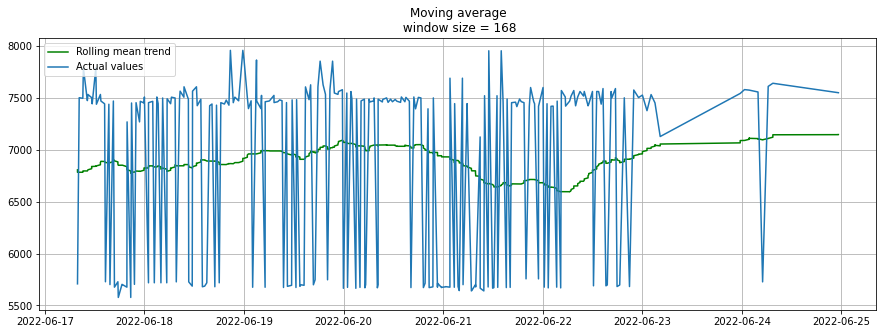

In [6]:
init_notebook_mode(connected = True)

def moving_average(series, n):
    return np.average(series[-n:])


def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


dataset = pd.read_csv('power.csv', index_col=['datetime'], parse_dates=['datetime'])

start_date = '15-06-2022'
end_date = '25-06-2022'
counter = 4101471

mask = (dataset.index > start_date) & (dataset.index <= end_date)
filtered_df = dataset
filtered_df = filtered_df.loc[mask]
filtered_df = filtered_df.loc[filtered_df["counter"] == counter].filter(items=["total"])
filtered_df = filtered_df.sort_index()

plotly_df(filtered_df, title = "Power")
print(moving_average(filtered_df.total, 1000000000))
plotMovingAverage(filtered_df, 24*7)

Критерий Дики-Фуллера: p=0.000084


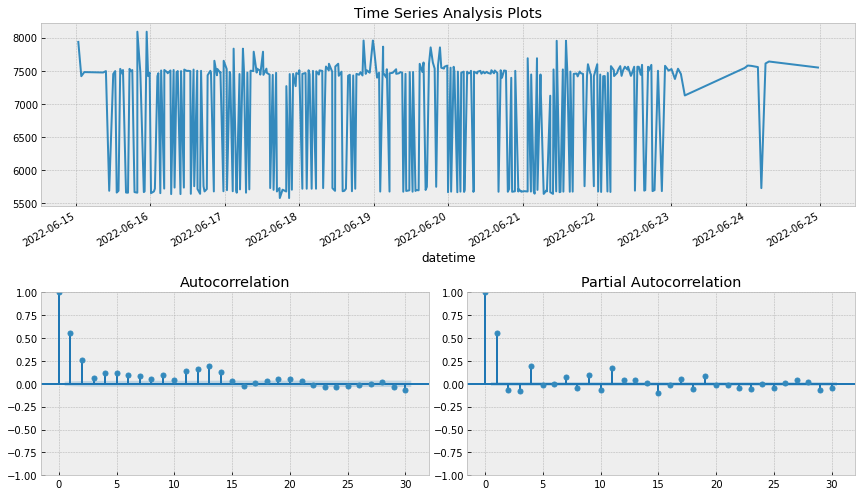

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(filtered_df.total, lags=30)

Критерий Дики-Фуллера: p=0.750077
Оптимальный параметр преобразования Бокса-Кокса: 6.212200


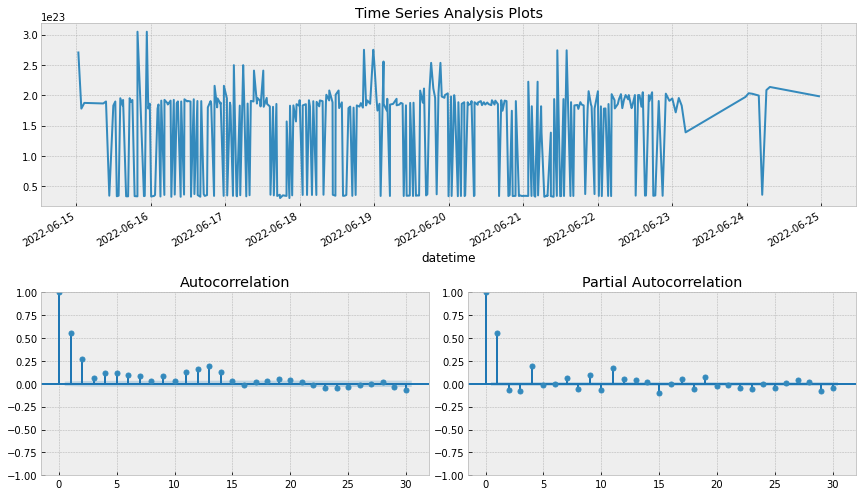

In [8]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = filtered_df.copy()
data['total_box'], lmbda = scs.boxcox(data.total+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.total_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.002386


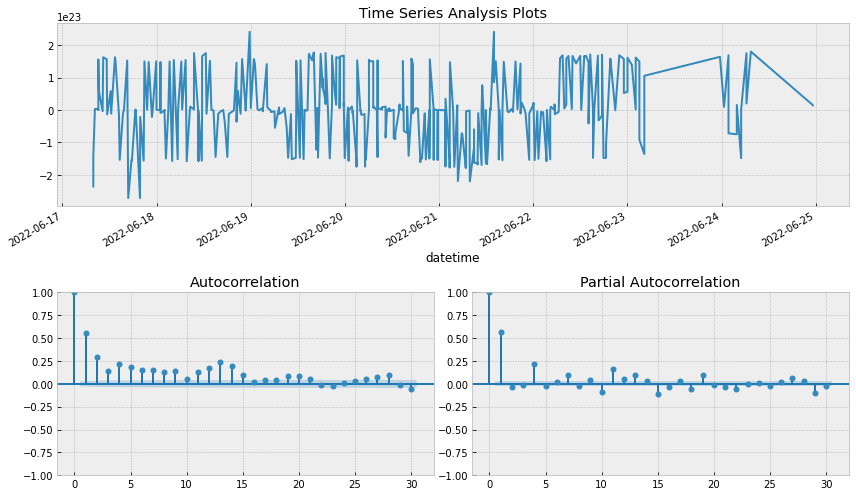

In [9]:
data['total_box_season'] = data.total_box - data.total_box.shift(24*7)
tsplot(data.total_box_season[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


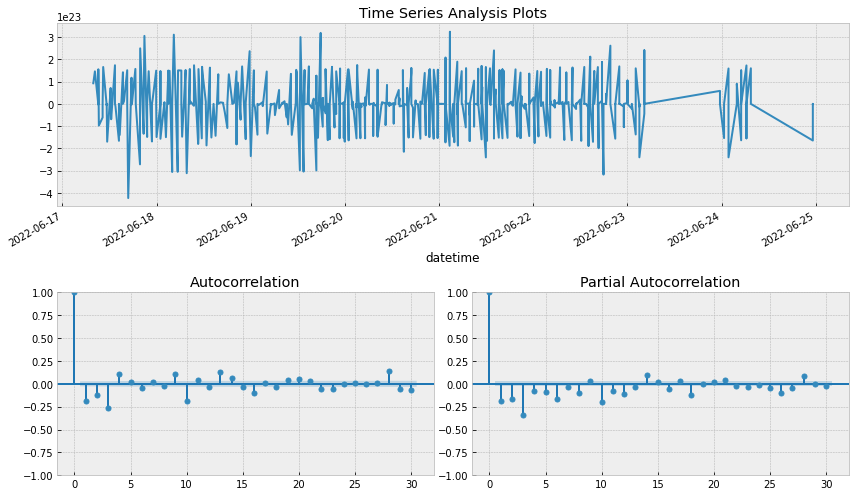

In [10]:
data['total_box_season_diff'] = data.total_box_season - data.total_box_season.shift(1)
tsplot(data.total_box_season_diff[24*7+1:], lags=30)

In [11]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [13]:
# %%time
# results = []
# best_aic = float("inf")
# counter = 0

# # data.index = pd.DatetimeIndex(data.index).to_period('M')

# for param in tqdm(parameters_list):
#     print("ITERATION", counter)
#     counter += 1
#     #try except нужен, потому что на некоторых наборах параметров модель не обучается
#     try:
#         model=sm.tsa.statespace.SARIMAX(data.total_box, order=(param[0], d, param[1]), 
#                                         seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
#     #выводим параметры, на которых модель не обучается и переходим к следующему набору
#     except ValueError:
#         print('wrong parameters:', param)
#         continue
#     aic = model.aic
#     #сохраняем лучшую модель, aic, параметры
#     if aic < best_aic:
#         print("FIND BETTER MODEL")
#         best_model = model
#         best_aic = aic
#         best_param = param
#         results.append([param, model.aic])

# warnings.filterwarnings('default')

# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())
import json
def estimateModel(file:str="last_model.json"):
    aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
    for p in range(6):
        for q in range(6):
            if p == 0 and q == 0:
                continue
            mod = sm.tsa.statespace.SARIMAX(data.total_box, order=(p,0,q), enforce_invertibility=False)
            # sm.tsa.arima.ARIMA(data.total_box, order=(p,0,q), enforce_invertibility=False)
            try:
                res = mod.fit(disp=False)
                aic_full.iloc[p,q] = res.aic
            except:
                aic_full.iloc[p,q] = np.nan
    aic_filter=np.nan_to_num(aic_full)
    p,q=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
    model=(int(p[0]),0,int(q[0]))
    with open(file,"w") as f:
        json.dump(model,f)
# self.fitModel(ts_columns)
    return model

model = estimateModel()
print(model)

(5, 0, 3)


In [14]:
def fitModel(model:dict=None):
    mod = sm.tsa.statespace.SARIMAX(data.total_box, order=model)
    mod_fit = mod.fit(disp=-1)
    return mod, mod_fit
mod, model_fit = fitModel(model)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              total_box   No. Observations:                  786
Model:               SARIMAX(5, 0, 3)   Log Likelihood              -42368.597
Date:                Sun, 09 Oct 2022   AIC                          84755.194
Time:                        23:16:55   BIC                          84797.197
Sample:                             0   HQIC                         84771.343
                                - 786                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0733      0.062      1.178      0.239      -0.049       0.195
ar.L2          0.9854      0.066     14.927      0.000       0.856       1.115
ar.L3          0.1811      0.084      2.167      0.0

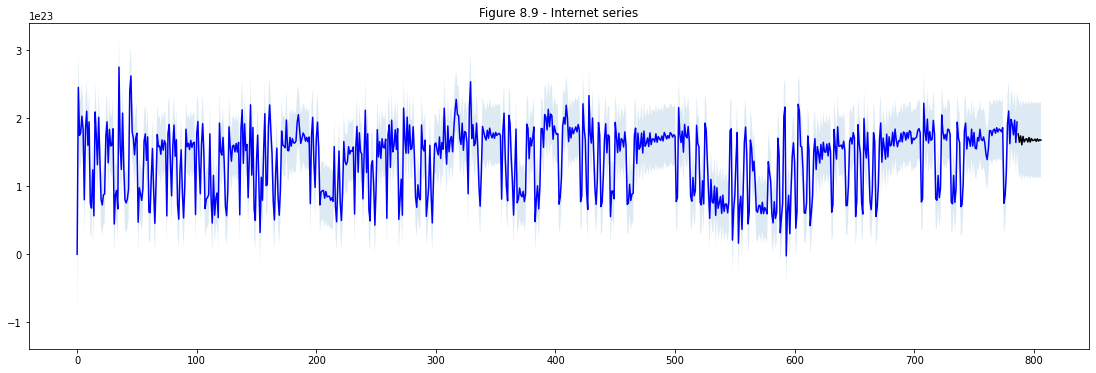

,lower total_box,upper total_box
0,-1.169122e+23,1.169122e+23
1,1.955428e+23,2.945762e+23
2,1.254950e+23,2.237714e+23
3,1.298832e+23,2.278673e+23
4,1.559818e+23,2.495441e+23
...,...,...
802,1.110764e+23,2.207714e+23
803,1.146005e+23,2.243359e+23
804,1.113734e+23,2.212272e+23
805,1.133653e+23,2.233027e+23


In [18]:
nforecast = 20
predict = model_fit.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)
# print(predict_ci.get("lower Deaths").values)
# Graph
fig, ax = plt.subplots(figsize=(19,6))
# ax.xaxis.grid()
# ax.plot(y, 'k.')
# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'black')
ax.fill_between(idx, predict_ci.get(predict_ci.columns[0]).values, predict_ci.get(predict_ci.columns[1]).values, alpha=0.15)
ax.set(title='Figure 8.9 - Internet series')
plt.show()
x=predict.predicted_mean[-nforecast:]
x
predict_ci

In [ ]:
# %%time
# best_model = sm.tsa.statespace.SARIMAX(data.total_box, order=(4, d, 3), 
#                                         seasonal_order=(4, D, 1, 24)).fit(disp=-1)
# print(best_model.summary())   